# **Predicting Problematic Internet Use**
### **December 25, 2024**


# **Introduction**

Goal: Predict the **Severity Impairment Index (SII)** based on behavioral and activity data provided in the dataset. This task is critical in identifying patterns that indicate problematic internet use among children and adolescents, enabling early interventions and support.

## **Problem Statement**
The target variable, **SII** (score on a scale of 0-5), is derived from a continuous variable, **PCIAT_Total**, which represents the aggregated scores of responses to 20 questions (PCIAT_XX) (Score on a scale of 0-20).

## **Key Challenges**
- **Missing Data in target and features**: Many of the `PCIAT_XX` columns have missing values, affecting the derived `PCIAT_Total` and `SII`.
- **Two target variables**: both PCIAT_Total and Sii are equivalent but have different prediction approaches (Regression vs Classification), therefore a choice has to be made.
- **High Dimensionality & Overfitting**: The dataset includes numerous features that may not all contribute significantly to the predictions, and are causing overfitting.

## **Outline**

1. **Exploratory Data Analysis (EDA)**  
   - Analysis of target variables (`SII` and `PCIAT_Total`).  
   - EDA of feature categories.  

2. **Baseline Models**  
   - Establish benchmark performance.  

3. **Final Modeling**  
   a. **Preprocessing**  
      - Data cleaning.  
      - PCA of time-series data.  
      - Feature engineering.  
      - Quantile bining.
      - Lasso imputation.  

   b. **Fine-tuning**  
      - Hyperparameter optimization for individual models.  

   c. **Final Model**  
      - Voting of 4 models  

4. **Submission**  
   - Generate and submit predictions.  




## **Data Overview**

### **1. Tabular Data (Train & Test)**
- **Demographics**: Age, sex.
- **Internet Use**: Hours/day.
- **Children's Global Assessment Scale**: Functioning scale for youths.
- **Physical Measures**: Blood pressure, heart rate, BMI, etc.
- **FitnessGram & Bio-electric Impedance**: Fitness and body composition.
- **Physical Activity Questionnaire**: Vigorous activities (7 days).
- **Sleep Disturbance Scale**: Categorizes sleep disorders.
- **PCIAT & sii**: target variables.
- **id**

### **2. Actigraphy Data (Train & Test)**
- **Series**: Continuous accelerometer data worn by certain patients for 30 days.
- **Fields**:
  - **id**: Participant identifier.
  - **X, Y, Z**: Acceleration (g).
  - **enmo**: Motion intensity (Euclidean norm).
  - **anglez**: Arm angle.
  - **non-wear_flag**: Indicates if the watch is worn.
  - **light, battery_voltage, time_of_day, weekday, quarter**: Contextual info.
  - **relative_date_PCIAT**: Days since PCIAT test.


##### import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/sample_submission.csv')
data_dictionary = pd.read_csv('/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/data_dictionary.csv')

### Tabular data: Train
#### Shape: 3960 records, 82 columns

In [ ]:
display(train.head())
print(f"Train shape: {train.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 82)


### Tabular data: Test
#### Shape: 20 records, 59 columns

In [ ]:
display(test.head())
print(f"Train shape: {test.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (20, 59)


### Data dictionary

In [ ]:
display(data_dictionary.head())
print(f"Dictionary shape: {data_dictionary.shape}")

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


Dictionary shape: (81, 6)


### Actigraphy Time series data


Code for parallelized computation of time series data

In [ ]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes

    return df

In [ ]:
# train_ts = load_time_series("/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/series_train.parquet")
# test_ts = load_time_series("/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/series_test.parquet")
# time_series_cols = train_ts.columns.tolist()
# time_series_cols.remove("id")

100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


In [ ]:
display(train_ts.head())

,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11,Stat_12,Stat_13,Stat_14,Stat_15,Stat_16,Stat_17,Stat_18,Stat_19,Stat_20,Stat_21,Stat_22,Stat_23,Stat_24,Stat_25,Stat_26,Stat_27,Stat_28,Stat_29,Stat_30,Stat_31,Stat_32,Stat_33,Stat_34,Stat_35,Stat_36,Stat_37,Stat_38,Stat_39,Stat_40,Stat_41,Stat_42,Stat_43,Stat_44,Stat_45,Stat_46,Stat_47,Stat_48,Stat_49,Stat_50,Stat_51,Stat_52,Stat_53,Stat_54,Stat_55,Stat_56,Stat_57,Stat_58,Stat_59,Stat_60,Stat_61,Stat_62,Stat_63,Stat_64,Stat_65,Stat_66,Stat_67,Stat_68,Stat_69,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79,Stat_80,Stat_81,Stat_82,Stat_83,Stat_84,Stat_85,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95,id
0,414384.0,414384.0,414384.0,414384.0,414384.0,414384.0,414384.0,414384.0,414384.0,414384.0,414384.0,414384.0,0.208036,0.057094,0.141550,0.030255,6.687338,0.171246,66.563408,3848.583252,4.318680e+13,3.832677,2.0,26.152903,0.487051,0.443697,0.682991,0.104177,52.752304,0.374540,286.954224,166.993835,2.494883e+13,1.951927,0.0,6.933428,-1.952594,-2.361866,-1.016758,0.0,-89.463226,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,14.0,-0.012729,-0.110418,-0.420154,0.000018,-25.106887,0.0,2.669909,3741.000000,2.158000e+13,2.0,2.0,20.0,0.194404,0.052310,0.333331,0.006382,19.556299,0.0,7.172272,3818.000000,4.316250e+13,4.0,2.0,26.0,0.606044,0.334034,0.714392,0.020465,45.880418,0.0,21.500000,3970.000000,6.481500e+13,6.0,2.0,32.0,1.666465,1.016429,2.239939,4.041167,89.862823,1.0,2611.000000,4187.0,8.639500e+13,7.0,2.0,38.0,00f332d1
1,370956.0,370956.0,370956.0,370956.0,370956.0,370956.0,370956.0,370956.0,370956.0,370956.0,370956.0,370956.0,-0.343396,-0.055826,-0.254433,0.032946,-17.589041,0.035210,17.800735,3849.649414,4.338433e+13,3.963284,4.0,49.910686,0.516083,0.424206,0.564573,0.083759,39.893372,0.183652,73.017166,171.147812,2.513356e+13,1.994539,0.0,6.201415,-2.284304,-2.276082,-1.022549,0.0,-89.877220,0.0,0.0,3098.166748,0.000000e+00,1.0,4.0,39.0,-0.784639,-0.312203,-0.753955,0.001059,-49.667419,0.0,2.500000,3740.833252,2.147500e+13,2.0,4.0,45.0,-0.473294,-0.018973,-0.354672,0.008127,-21.538264,0.0,6.677332,3827.833252,4.355500e+13,4.0,4.0,50.0,0.068885,0.206397,0.113704,0.026206,6.416064,0.0,17.742268,3982.000000,6.532000e+13,6.0,4.0,55.0,1.000692,1.011419,1.299293,4.097965,88.478432,1.0,2650.500000,4184.0,8.639500e+13,7.0,4.0,61.0,01085eb3
2,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,-0.004272,0.016859,-0.631731,0.011926,-55.630768,0.655708,16.771982,3838.189453,4.321212e+13,3.909848,3.0,79.435593,0.351582,0.303726,0.622458,0.024306,50.368004,0.467727,95.304085,155.542389,2.497264e+13,1.946892,0.0,6.633580,-1.038711,-1.522690,-1.018787,0.0,-88.761833,0.0,0.0,3098.166748,0.000000e+00,1.0,3.0,68.0,-0.052803,-0.044517,-1.009344,0.008622,-88.386049,0.0,0.500000,3747.000000,2.154000e+13,2.0,3.0,74.0,-0.020622,-0.028179,-1.007728,0.009831,-86.119919,1.0,0.879005,3812.000000,4.331000e+13,4.0,3.0,79.0,-0.019081,0.020307,-0.294459,0.010668,-17.483364,1.0,6.141348,3951.187561,6.485500e+13,6.0,3.0,85.0,1.034351,1.946303,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,001f3379
3,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.000000,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683,0.453665,0.502698,0.585710,0.106353,42.947163,0.000000,208.168869,112.401535,1.942842e+13,1.931421,0.0,14.245132,-1.746094,-2.905339,-1.048372,0.0,-89.833092,0.0,0.0,3824.000000,5.500000e+10,1.0,3.0,41.0,-0.684180,-0.309863,-0.649974,0.006432,-41.541863,0.0,2.392969,4028.666748,3.689000e+13,3.0,3.0,42.0,-0.366849,0.024974,-0.245378,0.023637,-15.086617,0.0,6.926828,4070.000000,5.347750e+13,5.0,3.0,50.0,-0.010677,0.400677,0.204727,0.041420,12.220764,0.0,15.000000,4147.000000,6.640875e+13,6.0,3.0,53.0,1.507865,1.666354,1.546979,4.

### Helper functions: calculate_stats, map_sii

In [ ]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

def map_sii_0_100(avg):
    if avg <= 30:
        return 0
    elif avg < 50:
        return 1
    elif avg < 80:
        return 2
    else:
        return 3

# EDA


## Missing Values


### Missing values percentage

#### Both train and test contain many missing values in almost every column, even in the target variable (for train).


In [ ]:
missing_values = train.isnull().sum()
percent_missing = (missing_values / len(train)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent Missing': percent_missing
}).sort_values(by='Percent Missing', ascending=False)

display(missing_summary)

,Missing Values,Percent Missing
PAQ_A-PAQ_A_Total,3485,88.005051
PAQ_A-Season,3485,88.005051
Fitness_Endurance-Time_Sec,3220,81.313131
Fitness_Endurance-Time_Mins,3220,81.313131
Fitness_Endurance-Max_Stage,3217,81.237374
...,...,...
PreInt_EduHx-Season,420,10.606061
Basic_Demos-Enroll_Season,0,0.000000
Basic_Demos-Sex,0,0.000000
Basic_Demos-Age,0,0.000000


### Missing values in target columns(Sii + PCIAT):

#### Missing values percentage



In [ ]:
target_cols = [col for col in train.columns if col.startswith('PCIAT-PCIAT_')] + ['sii']
missing_pciat_sii = train[target_cols].isnull().sum()
percent_missing_pciat_sii = (missing_pciat_sii / len(train)) * 100

missing_pciat_sii_summary = pd.DataFrame({
    'Missing Values': missing_pciat_sii,
    'Percent Missing': percent_missing_pciat_sii
}).sort_values(by='Percent Missing', ascending=False)
# Move 'sii' to the top of the DataFrame
missing_pciat_sii_summary = missing_pciat_sii_summary.reset_index()
missing_pciat_sii_summary.rename(columns={'index': 'Feature'}, inplace=True)
sii_row = missing_pciat_sii_summary[missing_pciat_sii_summary['Feature'] == 'sii']
missing_pciat_sii_summary = pd.concat([sii_row, missing_pciat_sii_summary[missing_pciat_sii_summary['Feature'] != 'sii']])

display(missing_pciat_sii_summary)

,Feature,Missing Values,Percent Missing
21,sii,1224,30.909091
0,PCIAT-PCIAT_17,1235,31.186869
1,PCIAT-PCIAT_18,1232,31.111111
2,PCIAT-PCIAT_16,1232,31.111111
3,PCIAT-PCIAT_05,1231,31.085859
4,PCIAT-PCIAT_07,1231,31.085859
5,PCIAT-PCIAT_13,1231,31.085859
6,PCIAT-PCIAT_08,1230,31.060606
7,PCIAT-PCIAT_09,1230,31.060606
8,PCIAT-PCIAT_19,1230,31.060606


#### Uncomplete PCIAT answers
#### Comment: Some questions in the Parent-Child Internet Addiction Test might be skipped by respondents (resulting in missing values in the columns PCIAT-PCIAT_01 through PCIAT-PCIAT_20). However, the SII is still calculated from the sum of the non-NA values, potentially leading to invalid SII values.

In [ ]:
columns_not_in_test = set(train.columns) - set(test.columns)
train_with_sii = train[train['sii'].notna()][list(columns_not_in_test)]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_13,PCIAT-PCIAT_10,PCIAT-PCIAT_02,PCIAT-PCIAT_05,PCIAT-PCIAT_14,PCIAT-PCIAT_12,PCIAT-PCIAT_20,PCIAT-PCIAT_18,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_11,PCIAT-PCIAT_16,PCIAT-PCIAT_09,sii,PCIAT-PCIAT_03,PCIAT-PCIAT_17,PCIAT-PCIAT_04,PCIAT-PCIAT_08,PCIAT-PCIAT_15,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_19,PCIAT-PCIAT_Total
24,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,Summer,2.000000,nan,30.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,nan,nan,nan,nan,nan,Fall,nan,nan,0.000000
104,2.000000,2.000000,2.000000,nan,2.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,4.000000,3.000000,2.000000,2.000000,3.000000,Fall,5.000000,3.000000,45.000000
141,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,4.000000,nan,2.000000,3.000000,3.000000,Winter,1.000000,2.000000,26.000000
142,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,Spring,2.000000,nan,26.000000


#### Sanity Check
Is PCIAT-PCIAT_Total accurately calculated as the sum of PCIAT-PCIAT_01 to PCIAT-PCIAT_20 skipping NA values?

In [ ]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-PCIAT_Total']).all()

True

Is Sii accurately calculated using the given 0-100 mapping?

In [ ]:
train['sii_calculated'] = train['PCIAT-PCIAT_Total'].apply(
    lambda x: map_sii_0_100(x) if pd.notna(x) else None
)
# Display the first few rows of calculated sii
flag = True

for i in range(len(train)):
    # Check for mismatches, ignoring rows where both are NaN
    if not (pd.isna(train.loc[i, 'sii']) and pd.isna(train.loc[i, 'sii_calculated'])):
        if train.loc[i, 'sii'] != train.loc[i, 'sii_calculated']:
            flag = False
            break  # Exit the loop as soon as a mismatch is found
train.drop('sii_calculated', axis=1, inplace=True)
print(flag)

True


#### Number of correctly answered rows (no missing answers in PCIAT_XX):

In [ ]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
correctly_answered_rows = train[PCIAT_cols].dropna().shape[0]

print(f"Number of correctly answered rows: {correctly_answered_rows}",f', Percentage: {round(correctly_answered_rows/len(train)*100,2)} %')

Number of correctly answered rows: 2671 , Percentage: 67.45 %


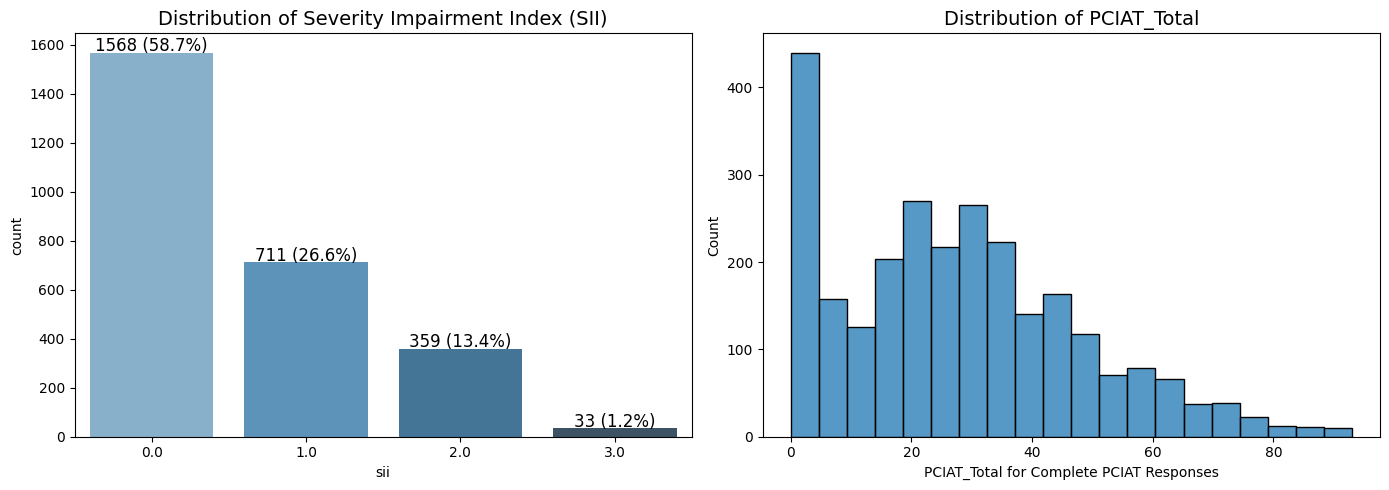

In [ ]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)
train = train.dropna(subset=['complete_resp_total'])
sii_counts = train['sii'].value_counts().reset_index()
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (SII)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

# EDA on feature categories

In [ ]:
print(f"Number of features excluding 'sii' and 'PCIAT-PCIAT_Total': {len(test.columns)}")

Number of features excluding 'sii' and 'PCIAT-PCIAT_Total': 59


**What i verify:**
1. correlation with target (sii and/or PCIAT)
2. missing values
3. reliability: measurements errors, inconsistencies/unlogical values

###1. Demographics (Age & Sex)


In [ ]:
print(train['Basic_Demos-Age'].isna().sum() == 0)
print(train['Basic_Demos-Sex'].isna().sum() == 0)

True
True


In [ ]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


In [ ]:
sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)
calculate_stats(train, 'Basic_Demos-Sex')

,count (%)
Basic_Demos-Sex,
Male,2484 (62.73%)
Female,1476 (37.27%)


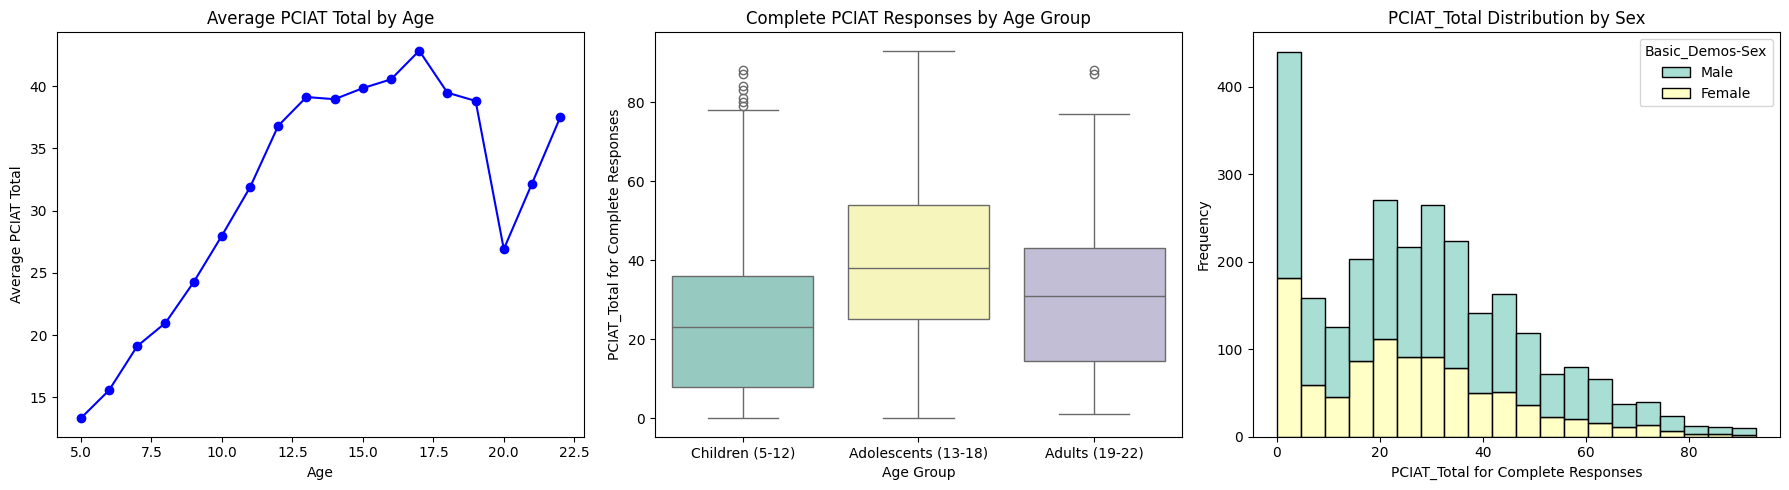

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


# Age Group vs complete_resp_total
# Calculate average PCIAT Total for each Age
age_pciat_avg = train.groupby('Basic_Demos-Age')['complete_resp_total'].mean().reset_index()

# PCIAT Total by Age (Line Plot)
axes[0].plot(age_pciat_avg['Basic_Demos-Age'], age_pciat_avg['complete_resp_total'], marker='o', color="blue")
axes[0].set_title('Average PCIAT Total by Age')
axes[0].set_ylabel('Average PCIAT Total')
axes[0].set_xlabel('Age')


# Complete PCIAT Responses by Age Group
sns.boxplot(
    x='Age Group', y='complete_resp_total',
    data=train, palette="Set3", ax=axes[1]
)
axes[1].set_title('Complete PCIAT Responses by Age Group')
axes[1].set_ylabel('PCIAT_Total for Complete Responses')
axes[1].set_xlabel('Age Group')

# PCIAT_Total by Sex
sns.histplot(
    data=train, x='complete_resp_total',
    hue='Basic_Demos-Sex', multiple='stack',
    palette="Set3", bins=20, ax=axes[2]
)
axes[2].set_title('PCIAT_Total Distribution by Sex')
axes[2].set_xlabel('PCIAT_Total for Complete Responses')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### **Comment**

- Positive correlation between **Severity Impairment Index (SII)** and **Age** until age 19:

    **Hypothesis**:
    - **SII peaks** during adolescence and starts to decline thereafter.
    - Or: Not enough data for patients aged >19 for the observation to be statistically valid.
    - Or: SII is evaluated by parents, and children above age 19 may no longer be in close contact with their parents.

- Little difference observed between genders in terms of PCIAT scores.


###2. Internet use (in hours)


##### internet use:

In [ ]:
calculate_stats(train, 'PreInt_EduHx-computerinternet_hoursday')

,count,mean,std,min,25%,50%,75%,max,missing
PreInt_EduHx-computerinternet_hoursday,,,,,,,,,
PreInt_EduHx-computerinternet_hoursday,2590.0,1.005792,1.07805,0.0,0.0,1.0,2.0,3.0,81


In [ ]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

In [ ]:
# sii_reported = train[train['sii'].notna()].copy()
sii_reported = train[train['complete_resp_total'].notna()].copy()
#sii_reported.loc[:, 'sii'] = sii_reported['sii'].cat.remove_unused_categories()
stats = sii_reported.groupby(
    ['internet_use_encoded', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,0.0,1.0,2.0,3.0
internet_use_encoded,,,,
Missing,52 (64.2%),15 (18.5%),14 (17.3%),0 (0.0%)
< 1h/day,923 (74.0%),245 (19.6%),74 (5.9%),5 (0.4%)
~ 1h/day,157 (47.4%),121 (36.6%),51 (15.4%),2 (0.6%)
~ 2hs/day,362 (47.5%),245 (32.2%),143 (18.8%),12 (1.6%)
> 3hs/day,74 (29.6%),85 (34.0%),77 (30.8%),14 (5.6%)


##### Plot

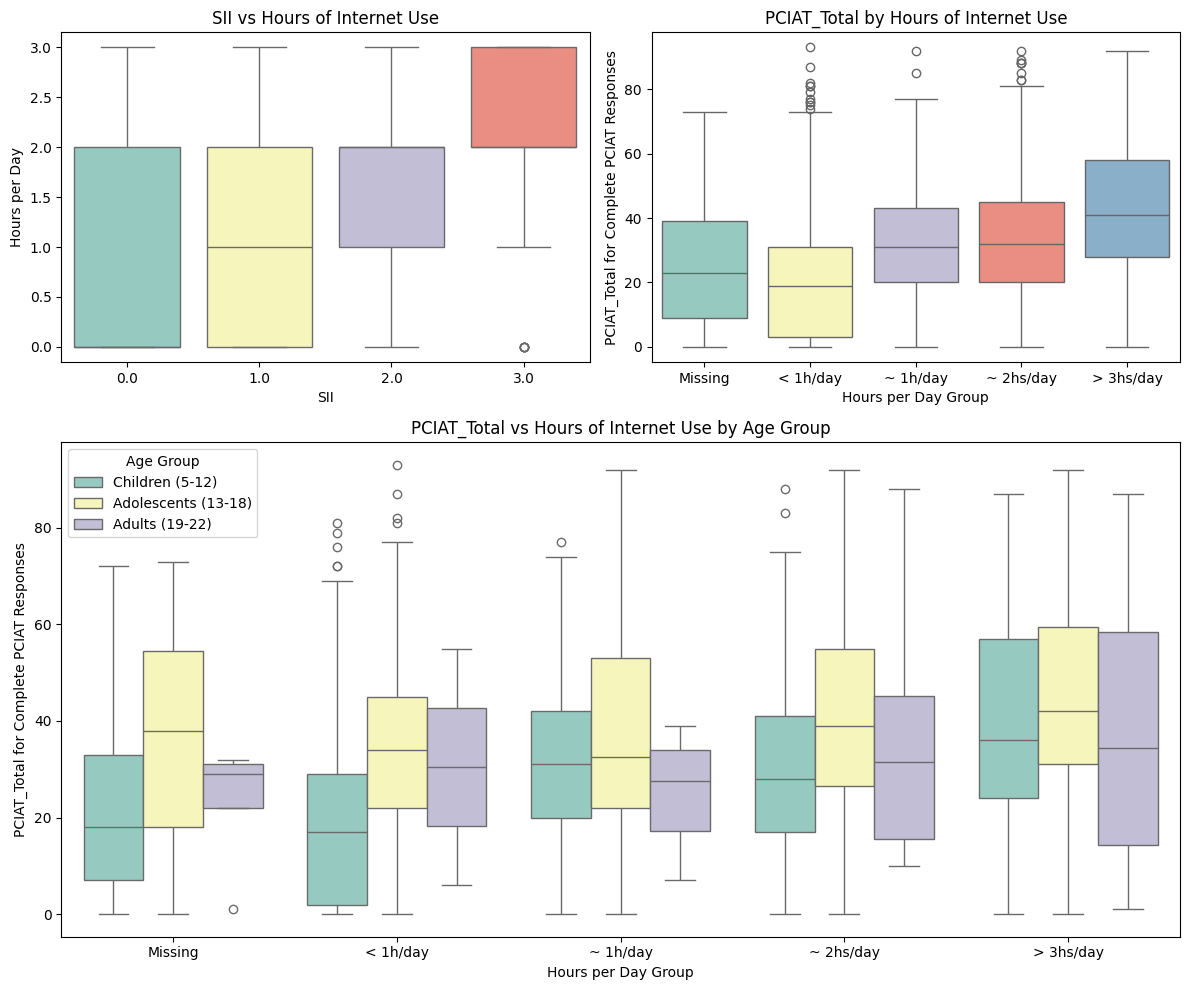

In [ ]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])

# SII vs Hours of Internet Use
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(
    x='sii', y='PreInt_EduHx-computerinternet_hoursday',
    data=sii_reported,
    ax=ax1, palette="Set3"
)
ax1.set_title('SII vs Hours of Internet Use')
ax1.set_ylabel('Hours per Day')
ax1.set_xlabel('SII')

# PCIAT_Total for Complete PCIAT Responses by Hours of Internet Use
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    palette="Set3", ax=ax2
)
ax2.set_title('PCIAT_Total by Hours of Internet Use')
ax2.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax2.set_xlabel('Hours per Day Group')

# SII vs Hours of Internet Use by Age Group (Full width)
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    hue='Age Group', ax=ax3, palette="Set3"
)
ax3.set_title('PCIAT_Total vs Hours of Internet Use by Age Group')
ax3.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax3.set_xlabel('Hours per Day Group')

plt.tight_layout()
plt.show()

#### **Comment**

- The correlation between **Severity Impairment Index (SII)** and **Internet Use Hours** is logical:
  - Minor problematic individuals show **either high PCIAT scores with low internet use** or **low PCIAT scores with high internet use**, indicating inconsistencies in how problematic behavior is reflected in the data.
  - This suggests that other factors, such as the nature of internet use or individual coping mechanisms, may influence the relationship.


###3. Mental Health (CGAS)


**Note about CGAS:** The Children’s Global Assessment Scale (CGAS) is a tool (Score from 0-100) used by clinicians to measure the general level of functioning in children and adolescents under the age of 18. It provides a single global score that reflects the child’s psychological, social, and academic functioning.

In [ ]:
calculate_stats(train, 'CGAS-CGAS_Score')

,count,mean,std,min,25%,50%,75%,max,missing
CGAS-CGAS_Score,,,,,,,,,
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.0,65.0,75.0,999.0,1539


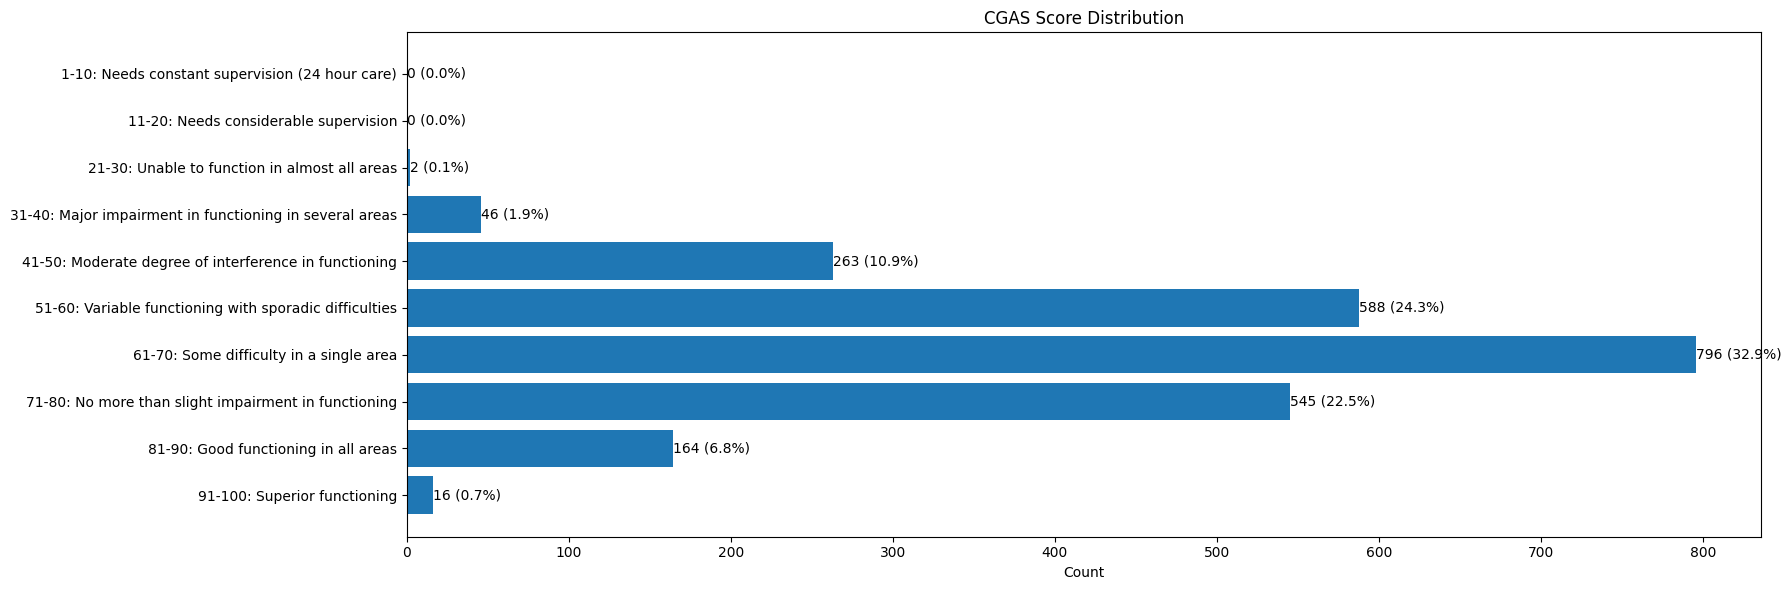

In [ ]:
bins = np.arange(0, 101, 10)
labels = [
    "1-10: Needs constant supervision (24 hour care)",
    "11-20: Needs considerable supervision",
    "21-30: Unable to function in almost all areas",
    "31-40: Major impairment in functioning in several areas",
    "41-50: Moderate degree of interference in functioning",
    "51-60: Variable functioning with sporadic difficulties",
    "61-70: Some difficulty in a single area",
    "71-80: No more than slight impairment in functioning",
    "81-90: Good functioning in all areas",
    "91-100: Superior functioning"
]

train['CGAS_Score_Bin'] = pd.cut(
    train['CGAS-CGAS_Score'], bins=bins, labels=labels
)

counts = train['CGAS_Score_Bin'].value_counts().reindex(labels)
prop = (counts / counts.sum() * 100).round(1)
count_prop_labels = counts.astype(str) + " (" + prop.astype(str) + "%)"

plt.figure(figsize=(18, 6))
bars = plt.barh(labels, counts)
plt.xlabel('Count')
plt.title('CGAS Score Distribution')

for bar, label in zip(bars, count_prop_labels):
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center'
    )

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
train_filt_cgas = train.dropna(subset=['CGAS_Score_Bin', 'complete_resp_total'])
train_filt_cgas.loc[:, 'CGAS_Score_Bin'] = train_filt_cgas['CGAS_Score_Bin'].cat.remove_unused_categories()
#train_filt.loc[:, 'sii'] = train_filt['sii'].cat.remove_unused_categories()
len(train_filt_cgas)

2288

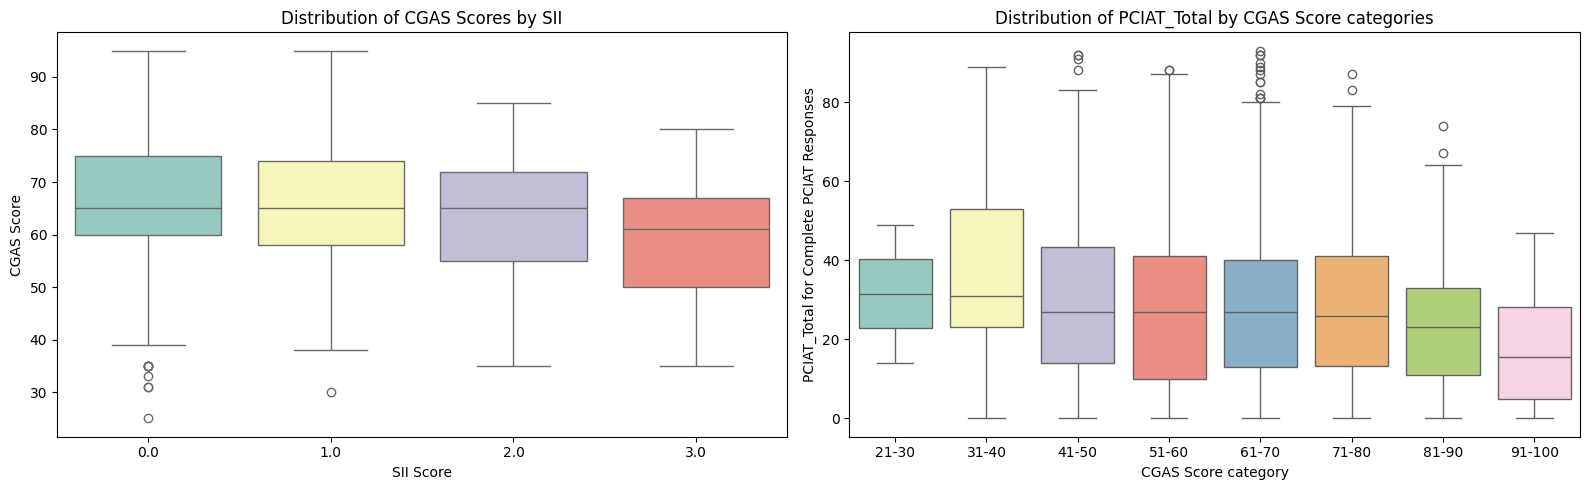

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# CGAS-CGAS_Score vs sii
sns.boxplot(
    data=train_filt_cgas,
    x='sii', y='CGAS-CGAS_Score',
    palette='Set3', ax=axes[0]
)
axes[0].set_xlabel('SII Score')
axes[0].set_ylabel('CGAS Score')
axes[0].set_title('Distribution of CGAS Scores by SII')

# complete_resp_total vs CGAS_Score_Bin
sns.boxplot(
    data=train_filt_cgas,
    x='CGAS_Score_Bin', y='complete_resp_total',
    ax=axes[1], palette='Set3'
)

# Get the tick positions and match the labels
range_labels = [label.split(":")[0] for label in train_filt_cgas['CGAS_Score_Bin'].cat.categories]
axes[1].set_xticklabels(range_labels)

axes[1].set_xlabel('CGAS Score category')
axes[1].set_ylabel('PCIAT_Total for Complete PCIAT Responses')
axes[1].set_title('Distribution of PCIAT_Total by CGAS Score categories')

plt.tight_layout()
plt.show()

#### **Comment**

- **Strong correlation** observed.
- **Missing Data**: 30% of the data is missing for **CGAS**.
- **Minor Inconsistencies**: Some entries have a score of `999`, which exceeds the maximum valid score of `100`.


###4. Physical Health (Physical Measures)

In [ ]:
groups = data_dictionary.groupby('Instrument')['Field'].apply(list).to_dict()
for instrument, features in groups.items():
    print(f"{instrument}: {features}\n")

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score']

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']

Identifier: ['id']

Internet Use: ['PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']

P

In [ ]:
features_physical = groups.get('Physical Measures', [])
continuous_cols = data_dictionary[data_dictionary['Type'].str.contains(
    'float|int', case=False
)]['Field'].tolist()
cols = [col for col in features_physical if col in continuous_cols]


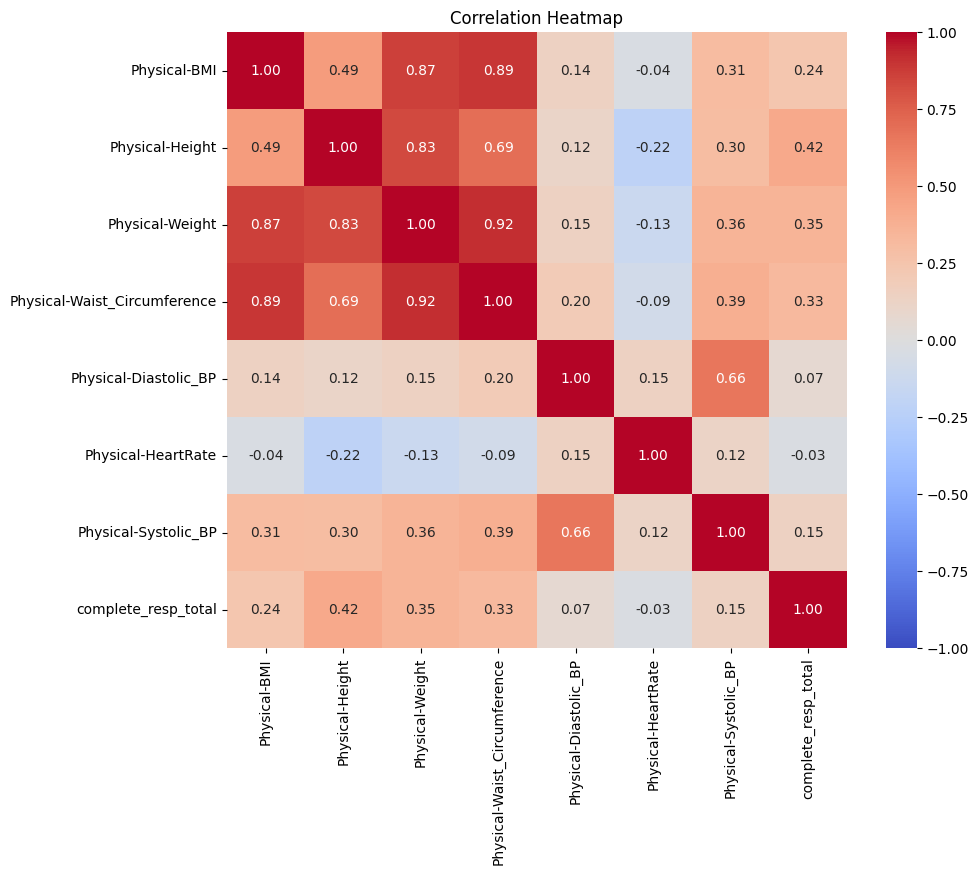

In [ ]:
data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

###5. Lifestyle (Fitness & Sleep)

#### a. Fitness


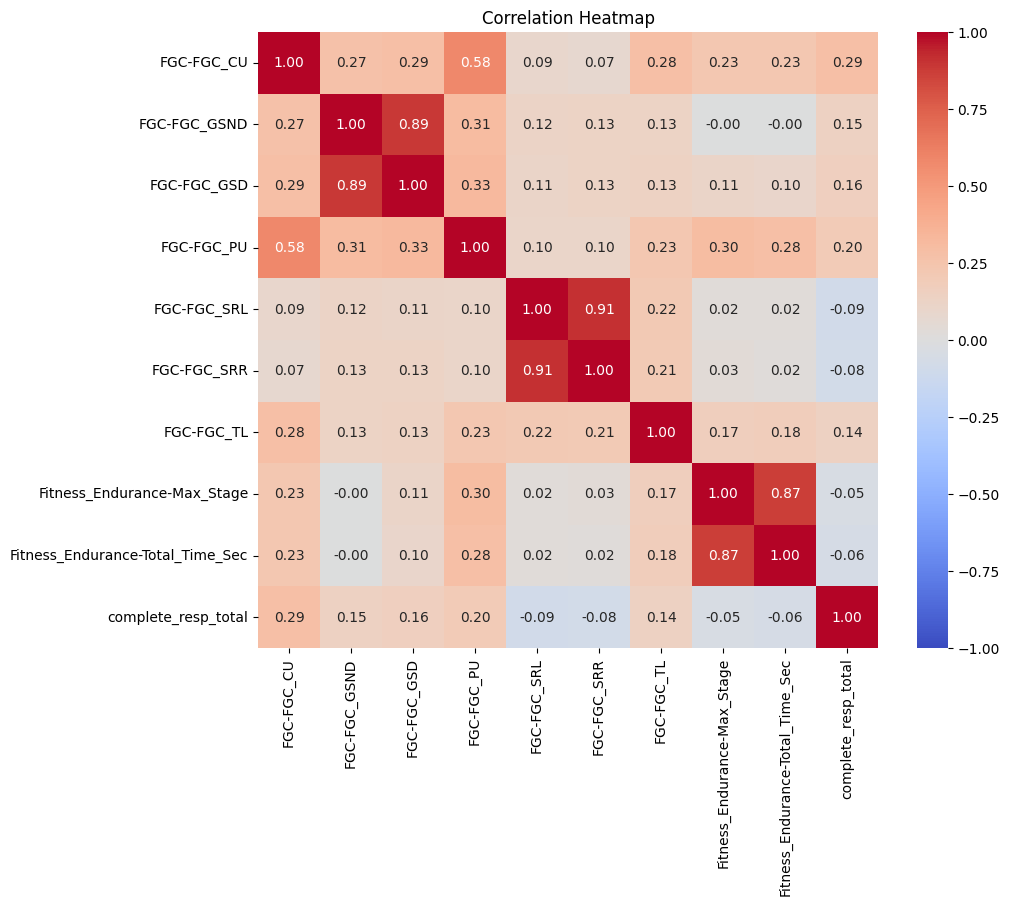

In [ ]:
cols = [
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec'
]
cols = [col for col in train.columns if col.startswith('FGC-')
        and 'Zone' not in col and 'Season' not in col]
cols.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

train['Fitness_Endurance-Total_Time_Sec'] = train[
    'Fitness_Endurance-Time_Mins'
] * 60 + train['Fitness_Endurance-Time_Sec']

data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#### **Comment**:
* Strong correlation between features:
  - Feature engineering
  - Remove certain features

#### b. Sleep disturbance scale

In [ ]:
calculate_stats(train, 'SDS-SDS_Total_T')

,count,mean,std,min,25%,50%,75%,max,missing
SDS-SDS_Total_T,,,,,,,,,
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.0,55.0,64.0,100.0,1354


Age range for participants with SDS-SDS_Total_Raw data: 5 - 22 years


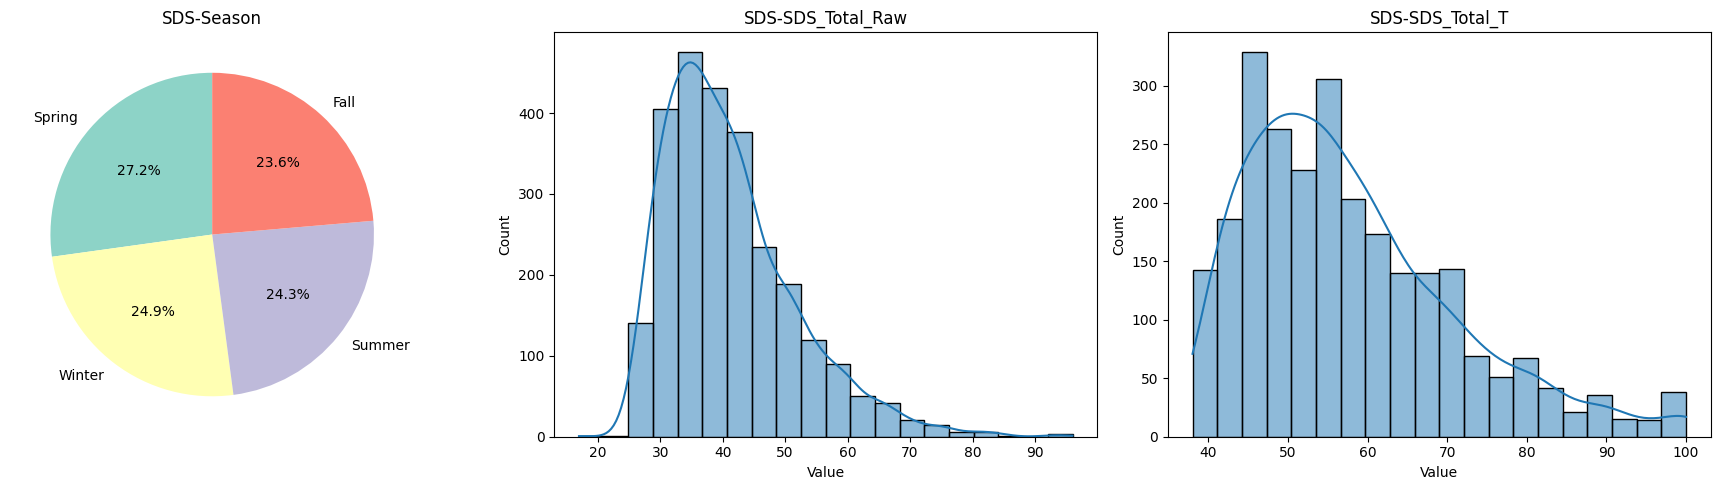

In [ ]:
groups.get('Sleep Disturbance Scale', [])
data = train[train['SDS-SDS_Total_Raw'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with SDS-SDS_Total_Raw data:"
    f" {age_range.min()} - {age_range.max()} years"
)
plt.figure(figsize=(18, 5))

# SDS-Season (Pie Chart)
plt.subplot(1, 3, 1)
sds_season_counts = train['SDS-Season'].value_counts(normalize=True)
plt.pie(
    sds_season_counts,
    labels=sds_season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('SDS-Season')

# SDS-SDS_Total_Raw
plt.subplot(1, 3, 2)
sns.histplot(train['SDS-SDS_Total_Raw'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_Raw')
plt.xlabel('Value')

# SDS-SDS_Total_T
plt.subplot(1, 3, 3)
sns.histplot(train['SDS-SDS_Total_T'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_T')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

#### SDS correlation with SII



In [ ]:
calculate_stats(train, 'SDS-SDS_Total_Raw')

,count,mean,std,min,25%,50%,75%,max,missing
SDS-SDS_Total_Raw,,,,,,,,,
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.0,39.0,46.0,96.0,1351


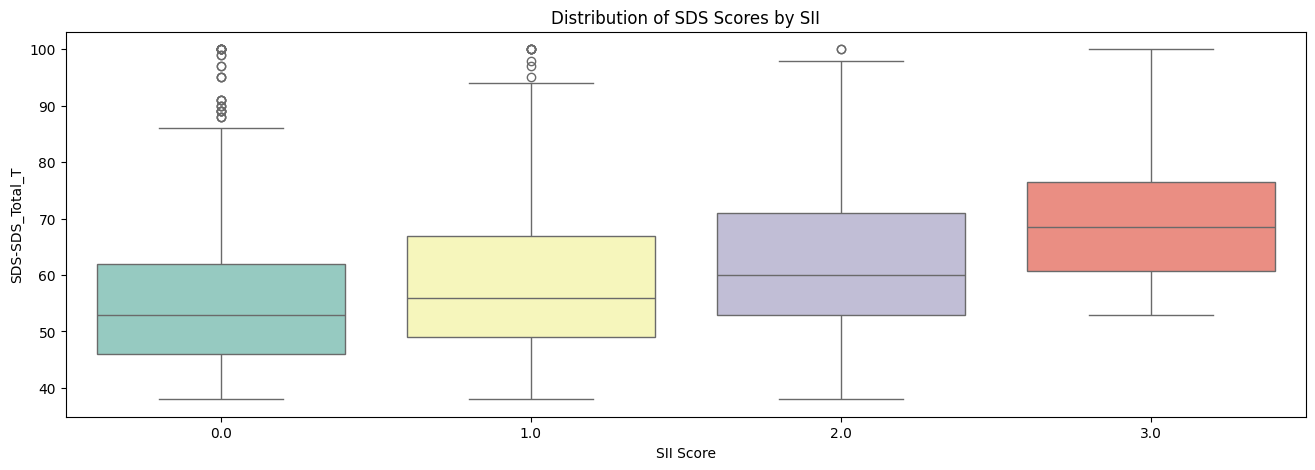

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

sns.boxplot(
    data=train_filt_cgas,
    x='sii', y='SDS-SDS_Total_T',
    palette='Set3', ax=ax
)
ax.set_xlabel('SII Score')
ax.set_ylabel('SDS-SDS_Total_T')
ax.set_title('Distribution of SDS Scores by SII')

plt.show()


#### **Comment**

- **Strong correlation** observed.
- **Missing Data**: 30% of the data is missing for **CGAS**.


# EDA comment: Problems/Observations to Consider in Modeling/Preprocessing



1. **Missing Data**:
   - Significant missing values in key features like `PCIAT_XX` and `CGAS` (~1/3 missing for CGAS).
   - Missing values directly affect derived features like `PCIAT_Total` and target variable `SII`.

2. **Inconsistent Values**:
   - Presence of invalid or outlier entries, e.g., `999` in `CGAS` (max valid score is `100`).
   - Zero or unrealistic values in features such as `PCIAT_XX`.

3. **Derived Target**:
   - `SII` is derived from `PCIAT_Total` thresholds, introducing dependency on accurate imputation of `PCIAT_XX`.

4. **Imbalanced Target Classes**:
   - Potential imbalance in `SII` class distribution, which may impact model performance.

5. **High Dimensionality**:
   - Many features (categorical and numerical), requiring dimensionality reduction or feature selection.

6. **Collinearity**:
   - Strong correlations observed among certain features, which could lead to redundancy.

7. **Limited Data for Certain Groups**:
   - Sparse data for individuals aged >19 may limit generalizability.

8. **Noise in Actigraphy Data**:
   - Actigraphy features may contain periods of inactivity or noise, requiring preprocessing (e.g., handling non-wear flags).

9. **Outliers**:
   - High variability and presence of extreme values in features like `Internet Use Hours`.

10. **Feature Engineering Challenges**:
    - Need to aggregate or derive new features (e.g., variability or consistency across `PCIAT_XX` responses).


# Baseline models

- **Regression on PCIAT-PCIAT_Total**

- **Pre-processing**
  - Consider only complete answers (drop rows where any `PCIAT_XX` is NaN).
  - Encode variables like Seasons (`Summer`, `Fall`, etc.).
  - Drop columns with more than 40% NA values, Imputate columns with more than 40% non-NA values using techniques like:
      - Median.
      - Mean.
      - KNN Imputer.

---

## **Model Selection(Initial Guess): Neural Network or Decision Tree (Gradient Boosting)**

### **Why Neural Networks?**
- **Data Complexity & High Dimensionality**:
  - Neural networks, if fine-tuned correctly, can capture complex, non-linear patterns in the data (as revealed by the EDA).
  - Recurrent Neural Networks (RNNs) are particularly well-suited for time-series data, such as actigraphy, which will be introduced later.
  **Cons**: Finding the right architecture and finetuning is time-consuming and expensive computatuonanly.

### **Why Decision Tree Models (Gradient Boosting)?**
- **Nature of the Data**:
  - The structure of the data naturally resembles a tree of possibilities:
    - **Example**: Splitting by gender, then by age group, and further by other features.
  - Decision-tree-based models like Gradient Boosting (e.g., XGBoost, LightGBM) are optimized for handling such hierarchical relationships efficiently.


**Sanity check:** Benchmark of most used models in Kaggle & Litterature:
Sources:
1. https://www.ieeexpert.com/python-projects/prediction-the-electronic-gadget-addiction-of-students-using-machine-learning/
2. Top 5 solutions on leaderboard are using Decision-tree based models:
https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/leaderboard



### **Baseline Models (Based on Benchmark)**

- **Gradient Boosting**:
  - LightGBMBoost.
  - XGBoost.
- **Naive Bayes**.

---

### **Metric** (K-Fold Cross validation)
1. **Accuracy**:  
   $$
   Accuracy = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
   $$

2. **Quadratic Cohen Kappa Score**:
   $$
   \kappa = \frac{1 - \sum_{i,j} w_{i,j} o_{i,j}}{1 - \sum_{i,j} w_{i,j} e_{i,j}}
   $$
   Where:
      - $w_{i,j}$: Weight for the agreement between categories.  
      - $o_{i,j}$: Observed agreement.  
      - $e_{i,j}$: Expected agreement by chance.

  **Note about Cohen Kappa Score**
      - **-1.0**: Complete disagreement.
      - **0.0**: Agreement due to chance only.
      - **0.41 - 0.60**: Moderate agreement.
      - **0.81 - 1.0**: Almost perfect agreement.



##### Pipeline

In [ ]:
def preprocess(dataset,scaling:bool,na_threshold=0,imput='none',target_imput=False):
    pciat_columns = [col for col in train.columns if col.startswith('PCIAT-PCIAT_') and col != 'PCIAT-PCIAT_Total']
    dataset_copy = dataset.copy()




    if target_imput:
      imputer_target = KNNImputer(n_neighbors=9, weights="distance")
      dataset_copy['complete_resp_total'] = imputer_target.fit_transform(dataset_copy[pciat_columns]).sum(axis=1).astype(int)
    else:
      dataset_copy['complete_resp_total'] = dataset_copy['PCIAT-PCIAT_Total'].where(
    dataset_copy[pciat_columns].notna().all(axis=1), np.nan
)


    dataset_copy.drop(columns=['id','PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
    'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
    'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
    'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
    'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
    'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total'],errors='ignore',inplace=True)

    #Drop Na in target:
    dataset_copy.dropna(subset=['complete_resp_total'],inplace=True)
    #Drop na threshold:
    dataset_copy.dropna(thresh=len(dataset_copy)*na_threshold,axis=1,inplace=True)

    #Objects:
    object_cols = dataset_copy.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in object_cols:
        le = LabelEncoder()
        dataset_copy[col] = le.fit_transform(dataset_copy[col].astype(str))
        label_encoders[col] = le  # Save encoders for potential inverse transformation
    # Imputing (using the median for numerical data)
    if imput!='none':
      if imput=='median':
        imputer = SimpleImputer(strategy='median')
      elif imput=='mean':
        imputer = SimpleImputer(strategy='mean')
      elif imput=='knn':
        imputer = KNNImputer(n_neighbors=9, weights="distance")
      dataset_copy.iloc[:, :] = imputer.fit_transform(dataset_copy)

    # Scaling (StandardScaler for KNN, Naive Bayes, or other distance-based models)
    if scaling:
        scaler = StandardScaler()
        dataset_copy.iloc[:, :-2] = scaler.fit_transform(dataset_copy)




    return dataset_copy
#train_filt = preprocess(train,'train',scaling=False,na_threshold=0)   #na_threshold: keep columns with at least na_thresold % non na

In [ ]:
def kfold(model,features, target,class_or_reg, n_splits=5):

    kf = KFold(n_splits=n_splits, shuffle=True)
    skf = kf

    # Lists to store scores
    accuracy_scores = []
    kappa_scores = []

    fold = 1
    for train_index, test_index in skf.split(features, target):
        print(f"Fold {fold}")
        fold += 1

        # Split data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        if class_or_reg == 'reg':
          y_pred = [map_sii_0_100(value) for value in y_pred]
          y_test = [map_sii_0_100(value) for value in y_test]



        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred, weights="quadratic")

        # Append scores
        accuracy_scores.append(accuracy)
        kappa_scores.append(kappa)

        # Print fold results
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Quadratic Kappa Score: {kappa:.4f}")
        print("-" * 50)

    # Print mean results
    print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Mean Quadratic Kappa Score: {np.mean(kappa_scores):.4f}")


In [ ]:
def predict(dataset,model,class_or_reg,imputer='median',na_thres=0,target_imput=False,scaling=False):


    if model in ['xgboost','lgbm','knn','nbayes']:
        dataset = preprocess(dataset,scaling=scaling,na_threshold=na_thres,imput=imputer,target_imput=target_imput)
        if class_or_reg == 'reg':
          dataset.drop(columns=['sii'],inplace=True)
          target_col = 'complete_resp_total'
        elif class_or_reg == 'class':
          dataset.drop(columns=['complete_resp_total'],inplace=True)
          target_col = 'sii'
        else:
          raise ValueError("class_or_reg must be 'reg' or 'class'")


    features = dataset.drop(columns=[target_col])  # Drop the target column
    target = dataset[target_col]

    print("Features:", features.columns)
    print("Target:", target_col)

    # Initialize the LightGBM model
    if model=='xgboost' and class_or_reg=='reg':
        model = XGBRegressor(**{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200})
    elif model=='lgbm' and class_or_reg=='class':
        model = LGBMClassifier()
    elif model=='knn' and  class_or_reg=='reg':
        model = KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')
    elif model=='nbayes' and class_or_reg=='reg':
        model = GaussianNB()
    else:
        raise ValueError("model must be 'xgboost' or 'lgbm' and reg/class")


    kfold(model,features, target,class_or_reg)


    #Prediction on train (Overfitting check):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
    model.fit(X_train, y_train)

    if class_or_reg == 'reg':
      y_train_pred_continuous = model.predict(X_train)
      y_train_pred = [map_sii_0_100(value) for value in y_train_pred_continuous]
      y_train_mapped = [map_sii_0_100(value) for value in y_train]
    else:
      y_train_pred = model.predict(X_train)
      y_train_mapped = y_train


    # Evaluate the model
    print("Training Accuracy:", accuracy_score(y_train_mapped, y_train_pred))
    print("Training Quadratic Kappa Score:", cohen_kappa_score(y_train_mapped, y_train_pred, weights="quadratic"))
    return model

### Predict

In [ ]:
# train_imput = create_sii_imput(train)
# train_imput['complete_resp_total'] = train_imput['PCIAT_Total_imput']
# train_imput.drop(columns=['PCIAT_Total_imput'],inplace=True)
pciat_columns = [col for col in train.columns if col.startswith('PCIAT-PCIAT_') and col != 'PCIAT-PCIAT_Total']
zero_counts = (train[pciat_columns] == 0).sum(axis=1)
train_filt = train[zero_counts <= 5]

model_pciat = predict(train_filt,model='xgboost',class_or_reg='reg',na_thres=0,imputer='none',target_imput=False)

Features: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_BMC', 'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
       'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'PC_1', 'PC_2', 'PC_3',
       'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11',
       'PC_12', 'PC_13', 'PC_14', 'PC_15', 'group', 'BMI_mean_norm',
       'FGC_Zones_mean', 'FGC_Zones_min', 'FGC_Zones_max', 'GS_max', 'GS_min',
       'CU_norm', 'PU_norm', 'TL_norm', 'SR_min', 'SR_max', 'BMR_norm',
       '

In [ ]:
from xgboost import plot_importance
def feature_importance_with_missing_values(model, data, importance_type='weight'):
    importance = model.get_booster().get_score(importance_type=importance_type)
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    })

    # Calculate percentage of missing values for each feature
    missing_values = data.isnull().mean() * 100
    missing_values_df = missing_values.reset_index()
    missing_values_df.columns = ['Feature', 'Missing_Percentage']

    # Merge feature importance with missing values
    merged_df = pd.merge(importance_df, missing_values_df, on='Feature', how='left')

    # Sort by importance
    merged_df = merged_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return merged_df

# Example usage
# Assuming 'model' is your trained XGBoost model and 'X_train' is your dataset:
feature_df = feature_importance_with_missing_values(model_pciat, train)
display(feature_df.head(30))



NameError: name 'model_pciat' is not defined

## Finetuning

In [ ]:
def finetune_model(dataset,model,class_or_reg,imputer='median',na_thres=0,target_imput=False):
    if model in ['xgboost','lgbm','knn','nbayes']:
        dataset = preprocess(dataset,scaling=False,na_threshold=na_thres,imput=imputer,target_imput=target_imput)
        if class_or_reg == 'reg':
          dataset.drop(columns=['sii'],inplace=True)
          target_col = 'complete_resp_total'
        elif class_or_reg == 'class':
          dataset.drop(columns=['complete_resp_total'],inplace=True)
          target_col = 'sii'
        else:
          raise ValueError("class_or_reg must be 'reg' or 'class'")


    features = dataset.drop(columns=[target_col])  # Drop the target column
    target = dataset[target_col]

    print("Features:", features.columns)
    print("Target:", target_col)


    # Initialize the base model and parameter grid
    if model == 'xgboost' and class_or_reg == 'reg':
        base_model = XGBRegressor()
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [50, 100, 200]
        }
        scoring = 'neg_mean_squared_error'
    elif model == 'lgbm' and class_or_reg == 'class':
        base_model = LGBMClassifier()
        param_grid = {
            'num_leaves': [31, 50, 70],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [50, 100, 200]
        }
        scoring = make_scorer(cohen_kappa_score, weights="quadratic")
    elif model == 'knn' and class_or_reg == 'reg':
        base_model = KNeighborsRegressor()
        param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
        scoring = 'neg_mean_squared_error'
    elif model == 'nbayes' and class_or_reg == 'class':
        base_model = GaussianNB()
        param_grid = {}  # Naive Bayes has no hyperparameters to tune
        scoring = make_scorer(cohen_kappa_score, weights="quadratic")
    else:
        raise ValueError("Invalid model type or class_or_reg")

    # Perform hyperparameter tuning
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(features, target)

    # Print best parameters and return the best model
    print("Best Parameters:", grid_search.best_params_ if param_grid else "No parameters to tune")
    best_model = grid_search.best_estimator_

    kfold(best_model,features, target,class_or_reg)


    #Prediction on train (Overfitting check):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    best_model.fit(X_train, y_train)
    if class_or_reg == 'reg':
      y_train_pred_continuous = best_model.predict(X_train)
      y_train_pred = [map_sii_0_100(value) for value in y_train_pred_continuous]
      y_train_mapped = [map_sii_0_100(value) for value in y_train]
    else:
      y_train_pred = best_model.predict(X_train)
      y_train_mapped = y_train


    # Evaluate the model
    print("Training Accuracy:", accuracy_score(y_train_mapped, y_train_pred))
    print("Training Quadratic Kappa Score:", cohen_kappa_score(y_train_mapped, y_train_pred, weights="quadratic"))


# Example usage:
# best_model = finetune_model('xgboost', 'reg', features, target)


In [ ]:
finetune_model(train,model='xgboost',class_or_reg='reg',na_thres=0,imputer='none',target_imput=False)

Features: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_BMC', 'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
       'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'PC_1', 'PC_2', 'PC_3',
       'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11',
       'PC_12', 'PC_13', 'PC_14', 'PC_15', 'group', 'BMI_mean_norm',
       'FGC_Zones_mean', 'FGC_Zones_min', 'FGC_Zones_max', 'GS_max', 'GS_min',
       'CU_norm', 'PU_norm', 'TL_norm', 'SR_min', 'SR_max', 'BMR_norm',
       '

# Final modeling:

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/test.csv')

In [ ]:
pciat_columns = [col for col in train.columns if col.startswith('PCIAT-PCIAT_') and col != 'PCIAT-PCIAT_Total']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[pciat_columns].notna().all(axis=1), np.nan
)
train = train.dropna(subset=['complete_resp_total'])
train.drop(columns=['complete_resp_total'],inplace=True)

## Pre-processing


1. **Data Cleaning**:  
   - Remove implausible or illogical values (e.g., body fat percentage under 5%, negative values).

2. **Feature Engineering**:  
   - Drop unnecessary or collinear features.  
   - Engineer new features to improve model performance.

3. **Actigraphy Data**:  
   - Scaling.  
   - Reduce dimensionality using PCA.

4. **Quantile Binning**:  
   - Create bins to group continuous features into quantiles.

5. **Lasso Imputation**:  
   - Impute features with more than 40% non-NA values using Lasso (L1) Regression.  
   - Impute the remaining features using the mean.


#### Data cleaning

In [ ]:
def clean_features(df):
    # Clip Grip
    df[['FGC-FGC_GSND', 'FGC-FGC_GSD']] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].clip(lower=9, upper=60)
    # Remove implausible body-fat
    df["BIA-BIA_Fat"] = np.where(df["BIA-BIA_Fat"] < 5, np.nan, df["BIA-BIA_Fat"])
    df["BIA-BIA_Fat"] = np.where(df["BIA-BIA_Fat"] > 60, np.nan, df["BIA-BIA_Fat"])
    # Basal Metabolic Rate
    df["BIA-BIA_BMR"] = np.where(df["BIA-BIA_BMR"] > 4000, np.nan, df["BIA-BIA_BMR"])
    # Daily Energy Expenditure
    df["BIA-BIA_DEE"] = np.where(df["BIA-BIA_DEE"] > 8000, np.nan, df["BIA-BIA_DEE"])
    # Bone Mineral Content
    df["BIA-BIA_BMC"] = np.where(df["BIA-BIA_BMC"] <= 0, np.nan, df["BIA-BIA_BMC"])
    df["BIA-BIA_BMC"] = np.where(df["BIA-BIA_BMC"] > 10, np.nan, df["BIA-BIA_BMC"])
    # Fat Free Mass Index
    df["BIA-BIA_FFM"] = np.where(df["BIA-BIA_FFM"] <= 0, np.nan, df["BIA-BIA_FFM"])
    df["BIA-BIA_FFM"] = np.where(df["BIA-BIA_FFM"] > 300, np.nan, df["BIA-BIA_FFM"])
    # Fat Mass Index
    df["BIA-BIA_FMI"] = np.where(df["BIA-BIA_FMI"] < 0, np.nan, df["BIA-BIA_FMI"])
    # Extra Cellular Water
    df["BIA-BIA_ECW"] = np.where(df["BIA-BIA_ECW"] > 100, np.nan, df["BIA-BIA_ECW"])
    # Lean Dry Mass
    df["BIA-BIA_LDM"] = np.where(df["BIA-BIA_LDM"] > 100, np.nan, df["BIA-BIA_LDM"])
    # Lean Soft Tissue
    df["BIA-BIA_LST"] = np.where(df["BIA-BIA_LST"] > 300, np.nan, df["BIA-BIA_LST"])
    # Skeletal Muscle Mass
    df["BIA-BIA_SMM"] = np.where(df["BIA-BIA_SMM"] > 300, np.nan, df["BIA-BIA_SMM"])
    # Total Body Water
    df["BIA-BIA_TBW"] = np.where(df["BIA-BIA_TBW"] > 300, np.nan, df["BIA-BIA_TBW"])

    return df

### Feature engineering

In [ ]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1)

    # From here on own features
    def assign_group(age):
        thresholds = [5, 6, 7, 8, 10, 12, 14, 17, 22]
        for i, j in enumerate(thresholds):
            if age <= j:
                return i
        return np.nan

    # Age groups
    df["group"] = df['Basic_Demos-Age'].apply(assign_group)

    # BMI
    BMI_map = {0: 16.3,1: 15.9,2: 16.1,3: 16.8,4: 17.3,5: 19.2,6: 20.2,7: 22.3, 8: 23.6}
    df['BMI_mean_norm'] = df[['Physical-BMI', 'BIA-BIA_BMI']].mean(axis=1) / df["group"].map(BMI_map)

    # FGC zone aggregate
    zones = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
             'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
             'FGC-FGC_TL_Zone']

    df['FGC_Zones_mean'] = df[zones].mean(axis=1)
    df['FGC_Zones_min'] = df[zones].min(axis=1)
    df['FGC_Zones_max'] = df[zones].max(axis=1)

    # Grip
    GSD_max_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 16.2, 5: 19.9, 6: 26.1, 7: 31.3, 8: 35.4}
    GSD_min_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 14.4, 5: 17.8, 6: 23.4, 7: 27.8, 8: 31.1}

    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1) / df["group"].map(GSD_max_map)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1) / df["group"].map(GSD_min_map)

    # Curl-ups, push-ups, trunk-lifts... normalized based on age-group
    cu_map = {0: 1.0, 1: 3.0, 2: 5.0, 3: 7.0, 4: 10.0, 5: 14.0, 6: 20.0, 7: 20.0, 8: 20.0}
    pu_map = {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0, 6: 8.0, 7: 10.0, 8: 14.0}
    tl_map = {0: 8.0, 1: 8.0, 2: 8.0, 3: 9.0, 4: 9.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0}

    df["CU_norm"] = df['FGC-FGC_CU'] / df['group'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['group'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['group'].map(tl_map)

    # Reach
    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

    # BIA Features
    # Energy Expenditure
    bmr_map = {0: 934.0, 1: 941.0, 2: 999.0, 3: 1048.0, 4: 1283.0, 5: 1255.0, 6: 1481.0, 7: 1519.0, 8: 1650.0}
    dee_map = {0: 1471.0, 1: 1508.0, 2: 1640.0, 3: 1735.0, 4: 2132.0, 5: 2121.0, 6: 2528.0, 7: 2566.0, 8: 2793.0}
    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["group"].map(dee_map)
    df["DEE_BMR"] = df["BIA-BIA_DEE"] - df["BIA-BIA_BMR"]

    # FMM
    ffm_map = {0: 42.0, 1: 43.0, 2: 49.0, 3: 54.0, 4: 60.0, 5: 76.0, 6: 94.0, 7: 104.0, 8: 111.0}
    df["FFM_norm"] = df["BIA-BIA_FFM"] / df["group"].map(ffm_map)

    # ECW ICW
    df["ICW_ECW"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]

    drop_feats = ['FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
                  'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
                  'Physical-BMI', 'BIA-BIA_BMI', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_Frame_num', "BIA-BIA_FFM"]
    df = df.drop(drop_feats, axis=1)
    return df

### Import actigraphy time series data, Scaling & PCA

In [ ]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(),
    ]

    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)

    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]

    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(),
            data.std(),
            data.max(),
            data.min(),
            data.diff().mean(),
            data.diff().std()
        ]

    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

# Code for parallelized computation of time series data from: Sheikh Muhammad Abdullah
# https://www.kaggle.com/code/abdmental01/cmi-best-single-model
def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes

    return df

In [ ]:
def perform_pca(train, test, n_components='mle', random_state=42):

    df_train = train.copy()
    df_test = test.copy()

    scaler = StandardScaler()
    df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
    df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)


    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(df_train)
    test_pca = pca.transform(df_test)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))

    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])

    return train_pca_df, test_pca_df, pca

### Quantile bining

In [ ]:
# Quantile bining:
def bin_data(train, test, columns, n_bins=10):
    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)

    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges
        edges = pd.qcut(combined[col], n_bins, retbins=True, labels=range(n_bins), duplicates="drop")[1]
        bin_edges[col] = edges

    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        train[col] = pd.cut(
            train[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
        test[col] = pd.cut(
            test[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)

    return train, test


### Lasso imputation

In [ ]:
class Impute_With_Model:

    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples

    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))

    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

## Final data

In [ ]:
train_ts = load_time_series("/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/content/gdrive/MyDrive/INWI_Case/child-mind-institute-problematic-internet-use/series_test.parquet")
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

for c in df_train.columns:
    m = np.mean(df_train[c])
    df_train[c].fillna(m, inplace=True)
    df_test[c].fillna(m, inplace=True)

print(df_train.shape)

df_train_pca, df_test_pca, pca = perform_pca(df_train, df_test, n_components=15, random_state=SEED)

df_train_pca['id'] = train_ts['id']
df_test_pca['id'] = test_ts['id']

train = pd.merge(train, df_train_pca, how="left", on='id')
test = pd.merge(test, df_test_pca, how="left", on='id')
train.shape

#clean
train = clean_features(train)
test = clean_features(test)

#feature_eng:
train = feature_engineering(train)
test = feature_engineering(test)

#bining
# Usage example
columns_to_bin = [
    "PAQ_A-PAQ_A_Total", "BMR_norm", "DEE_norm", "GS_min", "GS_max", "BIA-BIA_FFMI",
    "BIA-BIA_BMC", "Physical-HeartRate", "BIA-BIA_ICW", "Fitness_Endurance-Time_Sec",
    "BIA-BIA_LDM", "BIA-BIA_SMM", "BIA-BIA_TBW", "DEE_BMR", "ICW_ECW"
]
train, test = bin_data(train, test, columns_to_bin, n_bins=10)


# Features to exclude, because they're not in test
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
features = [f for f in train.columns if f not in exclude]

# Categorical features
# cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season',
#           'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
cat_c = []

for col in cat_c:
    a_map = {}
    all_unique = set(train[col].unique()) | set(test[col].unique())
    for i, value in enumerate(all_unique):
        a_map[value] = i

    train[col] = train[col].map(a_map)
    test[col] = test[col].map(a_map)



#train = train[train["sii"].notna()] # Keep rows where target is available



train.shape

100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


(996, 74)
Explained variance ratio of the components:
 [0.22212311 0.11408902 0.06616187 0.06116654 0.05273822 0.0458889
 0.0428315  0.03802907 0.03463458 0.02993016 0.02582637 0.02511987
 0.02317503 0.02173268 0.01984169]
0.8232886085143094


(2671, 83)

In [ ]:
model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4)
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, train, features)
train = imputer.impute(train)
test = imputer.impute(test)

100%|██████████| 60/60 [00:15<00:00,  3.83it/s]


In [ ]:
train_final = train.copy()

# Finetuning
The final model is an average of five treeboosters:
- LGBMRegressor
- 2 XGBRegressors
- CatBoostRegressor
- ExtraTreesRegressor



In [ ]:
def finetune_model(train,test):
    pciat_columns = [col for col in train.columns if col.startswith('PCIAT-PCIAT_') and col != 'PCIAT-PCIAT_Total']
    train_copy = train.copy()
    test_copy = test.copy()
    train_copy['complete_resp_total'] = train_copy['PCIAT-PCIAT_Total'].where(
    train_copy[pciat_columns].notna().all(axis=1), np.nan
)

    train_copy.drop(columns=['id','PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
    'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
    'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
    'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
    'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
    'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total','sii'],errors='ignore',inplace=True)
    #Drop Na in target:
    train_copy.dropna(subset=['complete_resp_total'],inplace=True)


    target_col = 'complete_resp_total'
    features = train_copy.drop(columns=[target_col])  # Drop the target column
    target = train_copy[target_col]

    print("Features:", features.columns)
    print("Target:", target_col)

    predictions_cont = []
    test_predictions_cont = []
    accuracies = []
    kappas = []
    params = {}

    models = {
        "LGBMRegressor": (LGBMRegressor(), {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]}),
        "XGBRegressor_1": (XGBRegressor(), {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200]}),
        "XGBRegressor_2": (XGBRegressor(), {'learning_rate': [0.01, 0.1], 'max_depth': [5, 7], 'n_estimators': [150, 250]}),
        "CatBoostRegressor": (CatBoostRegressor(verbose=0), {'learning_rate': [0.01, 0.1], 'depth': [4, 6]}),
        "ExtraTreesRegressor": (ExtraTreesRegressor(), {'n_estimators': [100, 200], 'max_depth': [None, 10]})
    }

    for model_name, (model, param_grid) in models.items():
        print(f"Tuning {model_name}...")
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=0)
        grid_search.fit(features, target)

        print(f"Best params for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {-grid_search.best_score_}")
        params[model_name] = grid_search.best_params_

        # Train the best model
        best_model = grid_search.best_estimator_
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
        best_model.fit(X_train, y_train)

        # Generate predictions
        train_pred_continous = best_model.predict(X_test)
        train_pred = [map_sii_0_100(value) for value in train_pred_continous]
        y_test_mapped = [map_sii_0_100(value) for value in y_test]
        predictions_cont.append(train_pred_continous)

        test_pred_continious = best_model.predict(test_copy[features.columns])
        test_pred = [map_sii_0_100(value) for value in test_pred_continious]
        test_predictions_cont.append(test_pred_continious)

        accuracy = accuracy_score(y_test_mapped, train_pred)
        kappa = cohen_kappa_score(y_test_mapped, train_pred, weights="quadratic")
        accuracies.append(accuracy)
        kappas.append(kappa)

        # Evaluate the model
        print(f"Training Accuracy for {model_name}:", accuracy)
        print(f"Training Quadratic Kappa Score for {model_name}:", kappa)

    # Average the predictions
    ensemble_train_predictions = [map_sii_0_100(value) for value in np.mean(predictions_cont, axis=0)]
    ensemble_test_predictions = [map_sii_0_100(value) for value in np.mean(test_predictions_cont, axis=0)]

    # Evaluate ensemble predictions
    print("Ensemble Training Accuracy:", np.mean(accuracies))
    print("Ensemble Training Quadratic Kappa Score:", np.mean(kappas))

finetune_model(train,test)

Features: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_BMC', 'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
       'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'PC_1', 'PC_2', 'PC_3',
       'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11',
       'PC_12', 'PC_13', 'PC_14', 'PC_15', 'group', 'BMI_mean_norm',
       'FGC_Zones_mean', 'FGC_Zones_min', 'FGC_Zones_max', 'GS_max', 'GS_min',
       'CU_norm', 'PU_norm', 'TL_norm', 'SR_min', 'SR_max', 'BMR_norm',
       '

In [ ]:
# Best params
params = {
    "CatBoostRegressor": {
        "depth": 6,
        "learning_rate": 0.01
    },
    "XGBRegressor_2": {
        "learning_rate": 0.01,
        "max_depth": 5,
        "n_estimators": 250
    },
    "XGBRegressor_1": {
        "learning_rate": 0.01,
        "max_depth": 5,
        "n_estimators": 200
    },
    "LGBMRegressor": {
        "learning_rate": 0.01,
        "n_estimators": 200
    },
    "ExtraTreesRegressor": {
        "max_depth": 10,
        "n_estimators": 200
    }
}



# Average of models - Final Model

In [ ]:
def sub_final(train, test):
    pciat_columns = [col for col in train.columns if col.startswith('PCIAT-PCIAT_') and col != 'PCIAT-PCIAT_Total']
    train_copy = train.copy()
    test_copy = test.copy()

    train_copy['complete_resp_total'] = train_copy['PCIAT-PCIAT_Total'].where(
        train_copy[pciat_columns].notna().all(axis=1), np.nan
    )
    train_copy.drop(columns=['id', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
                             'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
                             'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
                             'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
                             'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
                             'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii'],
                        errors='ignore', inplace=True)

    # Drop NaN in target
    train_copy.dropna(subset=['complete_resp_total'], inplace=True)

    target_col = 'complete_resp_total'
    features = train_copy.drop(columns=[target_col])  # Drop the target column
    target = train_copy[target_col]

    print("Features:", features.columns)
    print("Target:", target_col)

    predictions = []
    test_predictions = []

    # Predefined best models with tuned hyperparameters
    models = {
    "LGBMRegressor": LGBMRegressor(learning_rate=0.01, n_estimators=200),
    "XGBRegressor_1": XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=200),
    "XGBRegressor_2": XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=250),
    "CatBoostRegressor": CatBoostRegressor(learning_rate=0.01, depth=6, verbose=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=200, max_depth=10)
}


    for model_name, model in models.items():
        print(f"Training {model_name} with best parameters...")
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)

        # Generate predictions
        train_pred_continuous = model.predict(X_test)
        train_pred = [map_sii_0_100(value) for value in train_pred_continuous]
        y_test_mapped = [map_sii_0_100(value) for value in y_test]
        predictions.append(train_pred)

        test_pred_continuous = model.predict(test_copy[features.columns])
        test_predictions.append(test_pred_continuous)

        # Evaluate the model
        accuracy = accuracy_score(y_test_mapped, train_pred)
        kappa = cohen_kappa_score(y_test_mapped, train_pred, weights="quadratic")
        print(f"{model_name} Test MSE:", mean_squared_error(y_test, train_pred_continuous))
        print(f"Training Accuracy for {model_name}:", accuracy)
        print(f"Training Quadratic Kappa Score for {model_name}:", kappa)

    # Average the predictions
    ensemble_test_predictions = np.mean(test_predictions, axis=0)

    # Prepare the submission
    test_copy['sii'] = [map_sii_0_100(value) for value in ensemble_test_predictions]
    submission = test_copy[['id', 'sii']]
    submission.to_csv('submission.csv', index=False)

    print("Submission saved.")
    return submission



In [ ]:
submission = sub_final(train,test)
display(submission)

Features: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_BMC', 'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
       'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'PC_1', 'PC_2', 'PC_3',
       'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11',
       'PC_12', 'PC_13', 'PC_14', 'PC_15', 'group', 'BMI_mean_norm',
       'FGC_Zones_mean', 'FGC_Zones_min', 'FGC_Zones_max', 'GS_max', 'GS_min',
       'CU_norm', 'PU_norm', 'TL_norm', 'SR_min', 'SR_max', 'BMR_norm',
       '

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,1
8,0069fbed,1
9,0083e397,1


Features: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_BMC', 'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
       'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'PC_1', 'PC_2', 'PC_3',
       'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11',
       'PC_12', 'PC_13', 'PC_14', 'PC_15', 'group', 'BMI_mean_norm',
       'FGC_Zones_mean', 'FGC_Zones_min', 'FGC_Zones_max', 'GS_max', 'GS_min',
       'CU_norm', 'PU_norm', 'TL_norm', 'SR_min', 'SR_max', 'BMR_norm',
       '

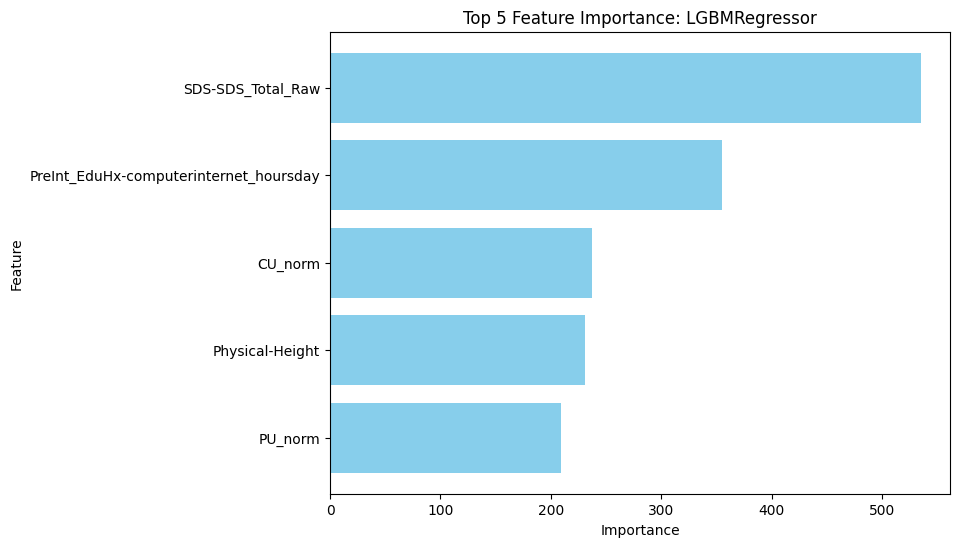

Training XGBRegressor_1 with best parameters...
XGBRegressor_1 Test MSE: 296.99114312054957
Training Accuracy for XGBRegressor_1: 0.6224299065420561
Training Quadratic Kappa Score for XGBRegressor_1: 0.3976301565077216

Top 5 Feature Importance for XGBRegressor_1:
                                    Feature  Importance
0                          Basic_Demos-Age    0.184640
26                         SDS-SDS_Total_T    0.058165
27  PreInt_EduHx-computerinternet_hoursday    0.051333
21                             BIA-BIA_SMM    0.023639
19                             BIA-BIA_LDM    0.023153


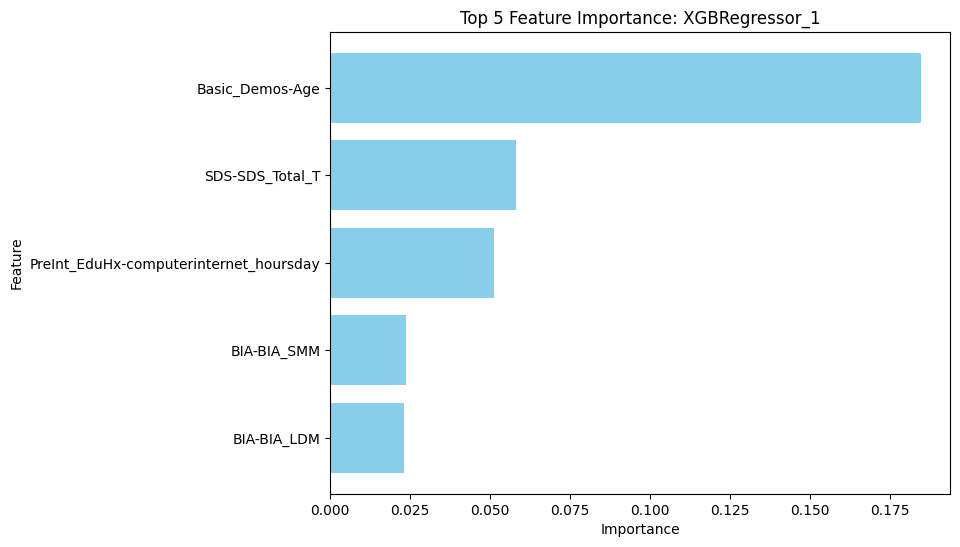

Training XGBRegressor_2 with best parameters...
XGBRegressor_2 Test MSE: 295.2127469710709
Training Accuracy for XGBRegressor_2: 0.6149532710280374
Training Quadratic Kappa Score for XGBRegressor_2: 0.4027155264410842

Top 5 Feature Importance for XGBRegressor_2:
                                    Feature  Importance
0                          Basic_Demos-Age    0.173096
26                         SDS-SDS_Total_T    0.061758
27  PreInt_EduHx-computerinternet_hoursday    0.050710
19                             BIA-BIA_LDM    0.024043
47                           FGC_Zones_max    0.023870


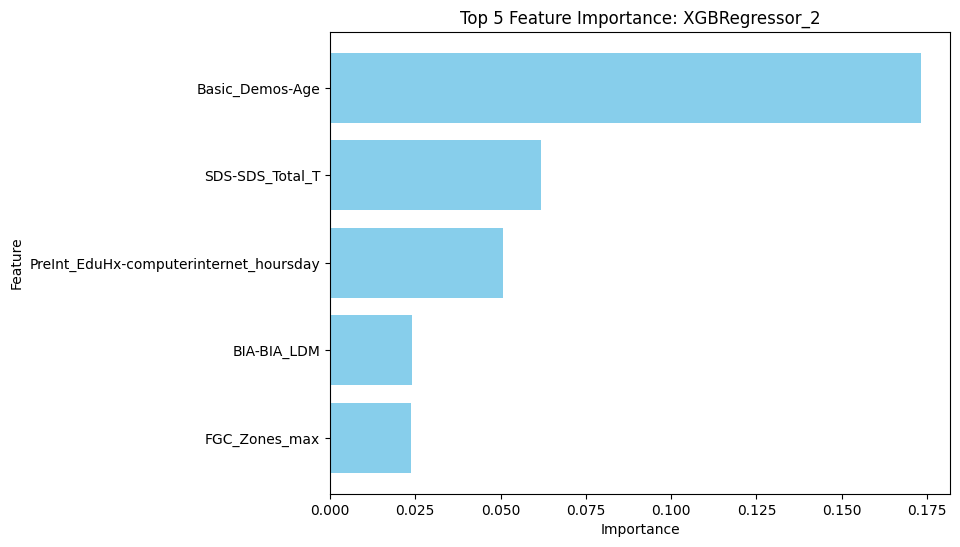

Training CatBoostRegressor with best parameters...
CatBoostRegressor Test MSE: 282.31248493588583
Training Accuracy for CatBoostRegressor: 0.6130841121495327
Training Quadratic Kappa Score for CatBoostRegressor: 0.3932874354561101

Top 5 Feature Importance for CatBoostRegressor:
                                    Feature  Importance
27  PreInt_EduHx-computerinternet_hoursday   11.582811
26                         SDS-SDS_Total_T    6.758999
25                       SDS-SDS_Total_Raw    6.398823
3                          Physical-Height    3.477178
0                          Basic_Demos-Age    3.311263


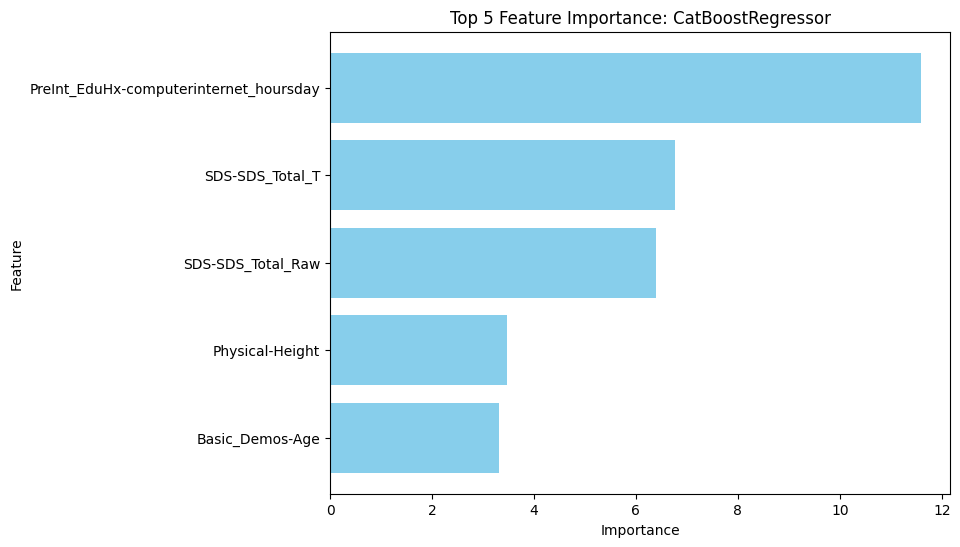

Training ExtraTreesRegressor with best parameters...
ExtraTreesRegressor Test MSE: 289.8662867217803
Training Accuracy for ExtraTreesRegressor: 0.6280373831775701
Training Quadratic Kappa Score for ExtraTreesRegressor: 0.41480967238059874

Top 5 Feature Importance for ExtraTreesRegressor:
                                    Feature  Importance
27  PreInt_EduHx-computerinternet_hoursday    0.124416
0                          Basic_Demos-Age    0.071494
43                                   group    0.062257
3                          Physical-Height    0.060959
26                         SDS-SDS_Total_T    0.057078


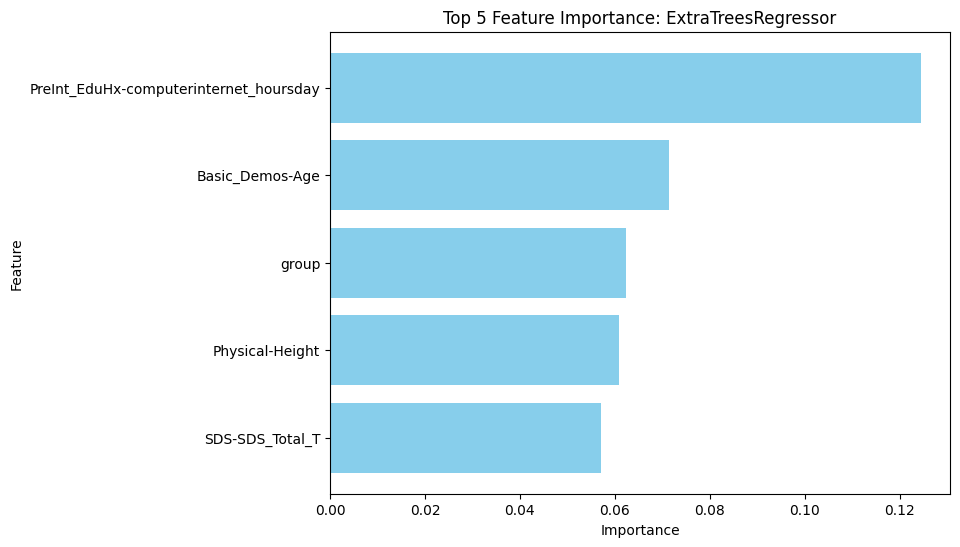

Submission saved.


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,1
8,0069fbed,1
9,0083e397,1


In [ ]:
def sub_final_with_top5_features(train, test):
    pciat_columns = [col for col in train.columns if col.startswith('PCIAT-PCIAT_') and col != 'PCIAT-PCIAT_Total']
    train_copy = train.copy()
    test_copy = test.copy()

    train_copy['complete_resp_total'] = train_copy['PCIAT-PCIAT_Total'].where(
        train_copy[pciat_columns].notna().all(axis=1), np.nan
    )
    train_copy.drop(columns=['id', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
                             'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
                             'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
                             'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
                             'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
                             'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii'],
                        errors='ignore', inplace=True)

    # Drop NaN in target
    train_copy.dropna(subset=['complete_resp_total'], inplace=True)

    target_col = 'complete_resp_total'
    features = train_copy.drop(columns=[target_col])  # Drop the target column
    target = train_copy[target_col]

    print("Features:", features.columns)
    print("Target:", target_col)

    predictions = []
    test_predictions = []

    # Predefined best models with tuned hyperparameters
    models = {
        "LGBMRegressor": LGBMRegressor(learning_rate=0.01, n_estimators=200, verbose=0),
        "XGBRegressor_1": XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=200, verbose=0),
        "XGBRegressor_2": XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=250, verbose=0),
        "CatBoostRegressor": CatBoostRegressor(learning_rate=0.01, depth=6, verbose=0),
        "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=200, max_depth=10, verbose=0)
    }

    for model_name, model in models.items():
        print(f"Training {model_name} with best parameters...")
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)

        # Generate predictions
        train_pred_continuous = model.predict(X_test)
        train_pred = [map_sii_0_100(value) for value in train_pred_continuous]
        y_test_mapped = [map_sii_0_100(value) for value in y_test]
        predictions.append(train_pred)

        test_pred_continuous = model.predict(test_copy[features.columns])
        test_predictions.append(test_pred_continuous)

        # Evaluate the model
        accuracy = accuracy_score(y_test_mapped, train_pred)
        kappa = cohen_kappa_score(y_test_mapped, train_pred, weights="quadratic")
        print(f"{model_name} Test MSE:", mean_squared_error(y_test, train_pred_continuous))
        print(f"Training Accuracy for {model_name}:", accuracy)
        print(f"Training Quadratic Kappa Score for {model_name}:", kappa)

        # Plot feature importance (only top 5 features)
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'Feature': features.columns,
                'Importance': model.feature_importances_
            }).sort_values(by='Importance', ascending=False).head(5)  # Top 5 features
            print(f"\nTop 5 Feature Importance for {model_name}:\n", importance_df)

            plt.figure(figsize=(8, 6))
            plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
            plt.title(f"Top 5 Feature Importance: {model_name}")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.gca().invert_yaxis()
            plt.show()

    # Average the predictions
    ensemble_test_predictions = np.mean(test_predictions, axis=0)

    # Prepare the submission
    test_copy['sii'] = [map_sii_0_100(value) for value in ensemble_test_predictions]
    submission = test_copy[['id', 'sii']]
    submission.to_csv('submission.csv', index=False)

    print("Submission saved.")
    return submission

sub_final_with_top5_features(train,test)

# References

- https://www.kaggle.com/code/c0ldzy/easy-silver-1-xgboost-no-tracker-data
- https://www.kaggle.com/competitions/-child-mind-institute-problematic-internet-use/discussion/552638
- https://www.kaggle.com/code/kienbeoo/child-mind-eda

#Librairies

In [ ]:
import sklearn
sklearn.__version__

'1.6.0'

In [ ]:
!pip install scikit-learn==1.6.0rc1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
!pip install polars optuna colorama tqdm lightgbm catboost xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from copy import deepcopy
from colorama import Fore, Style
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    cohen_kappa_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import VotingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from scipy.optimize import minimize
import optuna
import warnings
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer, mean_squared_error, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import PCA


# Suppress warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Define constants
n_splits = 5
SEED = 42


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
